
# 03 — Modeling Tabular

## Baselines + RNNs (LSTM, GRU, Dilated, Clockwork) con datos tabulados.

## Setup

In [5]:
from pathlib import Path
import os, json, math, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

### Reproducibility


In [6]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3050 Laptop GPU


### Config

In [7]:
DATA_CLEAN = Path("../data/clean/base_dataset.csv")   # generado en 02_*
OUT_DIR    = Path("../outputs"); OUT_DIR.mkdir(exist_ok=True)
FIG_DIR    = OUT_DIR / "figures"; FIG_DIR.mkdir(exist_ok=True, parents=True)
ART_DIR    = OUT_DIR / "artifacts"; ART_DIR.mkdir(exist_ok=True, parents=True)

TARGET_COL = "GHI"
FREQ = "10T"

# Ventanas
INPUT_STEPS = 36     # 36*10min = 6h de pasado
HORIZON_STEPS = 6    # 6*10min = 1h adelante (puedes variar)
BATCH_SIZE = 256
EPOCHS = 30
LR = 1e-3
PATIENCE = 5   # early stopping

## Loading Data

In [8]:
df = pd.read_csv(DATA_CLEAN, parse_dates=[0], index_col=0)
df.index.name = "time"
df = df.sort_index()

print(df.shape, df.index.min(), "→", df.index.max())
df.head()

(107172, 14) 2022-02-21 18:00:00+00:00 → 2024-03-06 23:50:00+00:00


,CSI,GHI,Presion,TempAmb,Wind Y,Wind X,DoY Sin,DoY Cos,horas,__missing_target,flag_GHI_range,flag_TempAmb_range,flag_Presion_range,flag_CSI_range
time,,,,,,,,,,,,,,
2022-02-21 18:00:00+00:00,2.0,3.0352,1000.7912,29.9672,2.832954,-0.093612,0.778764,0.627317,18,False,False,False,False,False
2022-02-21 18:10:00+00:00,0.0,0.3562,1000.9321,29.5689,3.387552,0.796801,0.778764,0.627317,18,False,False,False,False,False
2022-02-21 18:20:00+00:00,0.0,0.0000,1001.1479,29.2593,2.091197,-0.878680,0.778764,0.627317,18,False,False,False,False,False
2022-02-21 18:30:00+00:00,0.0,0.0000,1001.2992,28.9183,-0.487957,-1.478562,0.778764,0.627317,18,False,False,False,False,False
2022-02-21 18:40:00+00:00,0.0,0.0000,1001.4676,28.5578,0.891171,-2.047462,0.778764,0.627317,18,False,False,False,False,False


## Pre-modeling

### Feature Selection

In [9]:
bad_cols = [c for c in df.columns if c.startswith("flag_") or c.startswith("__")]
feat_cols = [c for c in df.columns if c not in bad_cols + [TARGET_COL]]
# feat_cols = [c for c in feat_cols if ("roll" in c) or ("hour_" in c) or c in ["TempAmb","Presion","Wind X","Wind Y","CSI","DoY Sin","DoY Cos"]]

len(feat_cols), feat_cols[:10]

(8,
 ['CSI',
  'Presion',
  'TempAmb',
  'Wind Y',
  'Wind X',
  'DoY Sin',
  'DoY Cos',
  'horas'])

### Train/Val/Test split

In [10]:
n = len(df)
i_tr = int(0.7*n)
i_va = int(0.85*n)

df_train = df.iloc[:i_tr].copy()
df_val   = df.iloc[i_tr:i_va].copy()
df_test  = df.iloc[i_va:].copy()

for name, part in [("train",df_train),("val",df_val),("test",df_test)]:
    print(name, part.index.min(), "→", part.index.max(), len(part))

train 2022-02-21 18:00:00+00:00 → 2023-07-27 17:10:00+00:00 75020
val 2023-07-27 17:20:00+00:00 → 2023-11-16 08:30:00+00:00 16076
test 2023-11-16 08:40:00+00:00 → 2024-03-06 23:50:00+00:00 16076


### Scaling

In [11]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = X_scaler.fit_transform(df_train[feat_cols].values)
y_train = y_scaler.fit_transform(df_train[[TARGET_COL]].values).ravel()

X_val = X_scaler.transform(df_val[feat_cols].values)
y_val = y_scaler.transform(df_val[[TARGET_COL]].values).ravel()

X_test = X_scaler.transform(df_test[feat_cols].values)
y_test = y_scaler.transform(df_test[[TARGET_COL]].values).ravel()

X_train.shape, X_val.shape, X_test.shape

((75020, 8), (16076, 8), (16076, 8))

## Baselines

In [12]:
def eval_regressor(model, X_tr, y_tr, X_te, y_te, y_scaler):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    # back to original units
    y_pred_orig = y_scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()
    y_true_orig = y_scaler.inverse_transform(y_te.reshape(-1,1)).ravel()
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    rmse = math.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mape = np.mean(np.abs((y_true_orig + 1e-6) - y_pred_orig) / (np.abs(y_true_orig) + 1e-6)) * 100
    return {"MAE":mae, "RMSE":rmse, "MAPE":mape}, (y_true_orig, y_pred_orig)

# Regresión Lineal
lin = LinearRegression()
lin_metrics, (y_true_lin, y_pred_lin) = eval_regressor(lin, X_train, y_train, X_test, y_test, y_scaler)
print("LinearRegression:", lin_metrics)

# Random Forest
rf = RandomForestRegressor(n_estimators=300, max_depth=None, n_jobs=-1, random_state=SEED)
rf_metrics, (y_true_rf, y_pred_rf) = eval_regressor(rf, X_train, y_train, X_test, y_test, y_scaler)
print("RandomForest:", rf_metrics)

LinearRegression: {'MAE': 229.8425056073718, 'RMSE': 284.70735500473313, 'MAPE': np.float64(5335738554.1385765)}
RandomForest: {'MAE': 35.16438880803289, 'RMSE': 57.4366355193224, 'MAPE': np.float64(602652693.2794726)}


## Sequential dataset (windows)

In [13]:
class SeqDataset(Dataset):
    def __init__(self, X, y, input_steps=36, horizon=6):
        self.X = X
        self.y = y
        self.input_steps = input_steps
        self.horizon = horizon
        # fin del índice que permite ventana completa + horizonte
        self.max_i = len(X) - input_steps - horizon
        assert self.max_i > 0, "No hay suficientes muestras para las ventanas."

    def __len__(self):
        return self.max_i

    def __getitem__(self, idx):
        i0 = idx
        i1 = idx + self.input_steps
        ih = i1 + self.horizon - 1
        x_seq = self.X[i0:i1]         # (T, F)
        y_tgt = self.y[ih]            # punto a H pasos
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_tgt, dtype=torch.float32)

def make_loaders(X_train, y_train, X_val, y_val, X_test, y_test, steps, horizon, batch=256):
    ds_tr = SeqDataset(X_train, y_train, steps, horizon)
    ds_va = SeqDataset(X_val, y_val, steps, horizon)
    ds_te = SeqDataset(X_test, y_test, steps, horizon)
    return (DataLoader(ds_tr, batch_size=batch, shuffle=True, drop_last=True),
            DataLoader(ds_va, batch_size=batch, shuffle=False, drop_last=False),
            DataLoader(ds_te, batch_size=batch, shuffle=False, drop_last=False))

dl_train, dl_val, dl_test = make_loaders(X_train, y_train, X_val, y_val, X_test, y_test,
                                         INPUT_STEPS, HORIZON_STEPS, BATCH_SIZE)
len(dl_train), len(dl_val), len(dl_test)

(292, 63, 63)

## PyTorch: LSTM, GRU, Dilated RNN, Clockwork RNN (simples)

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, in_dim, hidden=64, num_layers=1):
        super().__init__()
        self.rnn = nn.LSTM(input_size=in_dim, hidden_size=hidden, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.rnn(x)               # (B,T,H)
        out = out[:, -1, :]                # último paso
        return self.fc(out).squeeze(1)

class GRUModel(nn.Module):
    def __init__(self, in_dim, hidden=64, num_layers=1):
        super().__init__()
        self.rnn = nn.GRU(input_size=in_dim, hidden_size=hidden, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        return self.fc(out).squeeze(1)

class DilatedRNNCell(nn.Module):
    """Simple dilated RNN: procesa cada d-ésimo paso con mismo estado (demo)."""
    def __init__(self, in_dim, hidden):
        super().__init__()
        self.Wx = nn.Linear(in_dim, hidden)
        self.Wh = nn.Linear(hidden, hidden)
        self.act = nn.Tanh()
    def forward(self, x_t, h):
        return self.act(self.Wx(x_t) + self.Wh(h))

class DilatedRNN(nn.Module):
    def __init__(self, in_dim, hidden=64, dilation=2):
        super().__init__()
        self.cell = DilatedRNNCell(in_dim, hidden)
        self.fc = nn.Linear(hidden, 1)
        self.d = dilation
    def forward(self, x):
        B, T, F = x.size()
        h = torch.zeros(B, self.fc.in_features, device=x.device)
        for t in range(0, T, self.d):
            h = self.cell(x[:, t, :], h)
        return self.fc(h).squeeze(1)

class ClockworkRNN(nn.Module):
    """Versión simplificada: divide hidden en módulos con periodos distintos."""
    def __init__(self, in_dim, hidden=60, modules=3):
        super().__init__()
        assert hidden % modules == 0
        self.modules = modules
        self.h_per = hidden // modules
        self.periods = [1, 2, 4][:modules]   # puedes ajustar
        self.Wx = nn.ModuleList([nn.Linear(in_dim, self.h_per) for _ in range(modules)])
        self.Wh = nn.ModuleList([nn.Linear(self.h_per, self.h_per) for _ in range(modules)])
        self.act = nn.Tanh()
        self.fc  = nn.Linear(hidden, 1)

    def forward(self, x):
        B, T, F = x.size()
        hs = [torch.zeros(B, self.h_per, device=x.device) for _ in range(self.modules)]
        for t in range(T):
            for m in range(self.modules):
                if t % self.periods[m] == 0:
                    hs[m] = self.act(self.Wx[m](x[:, t, :]) + self.Wh[m](hs[m]))
        h_all = torch.cat(hs, dim=1)
        return self.fc(h_all).squeeze(1)

## Training

In [15]:
def train_model(model, dl_train, dl_val, epochs=30, lr=1e-3, patience=5, device=DEVICE):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    no_improve = 0
    history = {"train": [], "val": []}

    for ep in range(1, epochs+1):
        model.train()
        tr_losses = []
        for xb, yb in dl_train:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            tr_losses.append(loss.item())

        model.eval()
        va_losses = []
        with torch.no_grad():
            for xb, yb in dl_val:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = loss_fn(pred, yb)
                va_losses.append(loss.item())

        tr, va = np.mean(tr_losses), np.mean(va_losses)
        history["train"].append(tr); history["val"].append(va)

        print(f"Epoch {ep:02d} | train MSE {tr:.4f} | val MSE {va:.4f}")

        if va < best_val - 1e-6:
            best_val = va
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

## Fit

In [16]:
in_dim = X_train.shape[1]

models_cfg = {
    "LSTM":       LSTMModel(in_dim, hidden=64, num_layers=1),
    "GRU":        GRUModel(in_dim, hidden=64, num_layers=1),
    "DilatedRNN": DilatedRNN(in_dim, hidden=64, dilation=3),
    "Clockwork":  ClockworkRNN(in_dim, hidden=60, modules=3),
}

trained = {}
histories = {}

for name, model in models_cfg.items():
    print(f"\n=== Training {name} ===")
    m, h = train_model(model, dl_train, dl_val, epochs=EPOCHS, lr=LR, patience=PATIENCE, device=DEVICE)
    trained[name] = m
    histories[name] = h


=== Training LSTM ===
Epoch 01 | train MSE 0.2116 | val MSE 0.1239
Epoch 02 | train MSE 0.1084 | val MSE 0.1170
Epoch 03 | train MSE 0.0944 | val MSE 0.1097
Epoch 04 | train MSE 0.0884 | val MSE 0.1078
Epoch 05 | train MSE 0.0850 | val MSE 0.1044
Epoch 06 | train MSE 0.0826 | val MSE 0.1151
Epoch 07 | train MSE 0.0805 | val MSE 0.1073
Epoch 08 | train MSE 0.0794 | val MSE 0.1015
Epoch 09 | train MSE 0.0774 | val MSE 0.1051
Epoch 10 | train MSE 0.0766 | val MSE 0.1060
Epoch 11 | train MSE 0.0749 | val MSE 0.1062
Epoch 12 | train MSE 0.0739 | val MSE 0.1063
Epoch 13 | train MSE 0.0728 | val MSE 0.1078
Early stopping.

=== Training GRU ===
Epoch 01 | train MSE 0.2270 | val MSE 0.1341
Epoch 02 | train MSE 0.1148 | val MSE 0.1251
Epoch 03 | train MSE 0.1020 | val MSE 0.1185
Epoch 04 | train MSE 0.0951 | val MSE 0.1141
Epoch 05 | train MSE 0.0907 | val MSE 0.1115
Epoch 06 | train MSE 0.0869 | val MSE 0.1081
Epoch 07 | train MSE 0.0843 | val MSE 0.1076
Epoch 08 | train MSE 0.0821 | val MSE 0

## Test

In [17]:
def evaluate_sequence_model(model, dl, y_scaler, device=DEVICE):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device)
            p = model(xb).cpu().numpy()
            preds.append(p)
            trues.append(yb.cpu().numpy())
    pred = np.concatenate(preds)
    true = np.concatenate(trues)
    # back-transform
    pred_orig = y_scaler.inverse_transform(pred.reshape(-1,1)).ravel()
    true_orig = y_scaler.inverse_transform(true.reshape(-1,1)).ravel()
    mae = mean_absolute_error(true_orig, pred_orig)
    rmse = math.sqrt(mean_squared_error(true_orig, pred_orig))
    mape = np.mean(np.abs((true_orig + 1e-6) - pred_orig) / (np.abs(true_orig) + 1e-6)) * 100
    return {"MAE":mae, "RMSE":rmse, "MAPE":mape}, (true_orig, pred_orig)

results = {"LinearRegression": lin_metrics, "RandomForest": rf_metrics}
series_preds = {}

for name, model in trained.items():
    metrics, (y_true, y_pred) = evaluate_sequence_model(model, dl_test, y_scaler)
    results[name] = metrics
    series_preds[name] = (y_true, y_pred)

results

{'LinearRegression': {'MAE': 229.8425056073718,
  'RMSE': 284.70735500473313,
  'MAPE': np.float64(5335738554.1385765)},
 'RandomForest': {'MAE': 35.16438880803289,
  'RMSE': 57.4366355193224,
  'MAPE': np.float64(602652693.2794726)},
 'LSTM': {'MAE': 55.324989318847656,
  'RMSE': 92.24878789007202,
  'MAPE': np.float32(97461360.0)},
 'GRU': {'MAE': 51.02140426635742,
  'RMSE': 91.44604902789678,
  'MAPE': np.float32(50526140.0)},
 'DilatedRNN': {'MAE': 59.804874420166016,
  'RMSE': 98.63727248579768,
  'MAPE': np.float32(100038210.0)},
 'Clockwork': {'MAE': 64.30062866210938,
  'RMSE': 102.41319685775365,
  'MAPE': np.float32(154201330.0)}}

## Plots

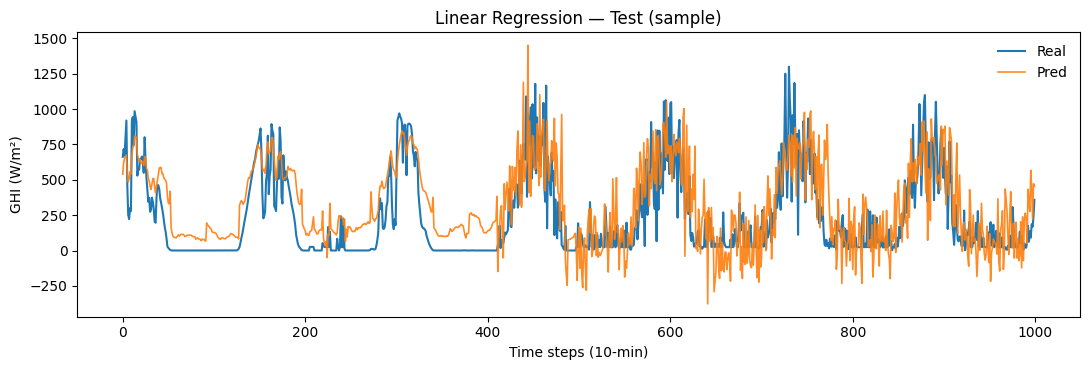

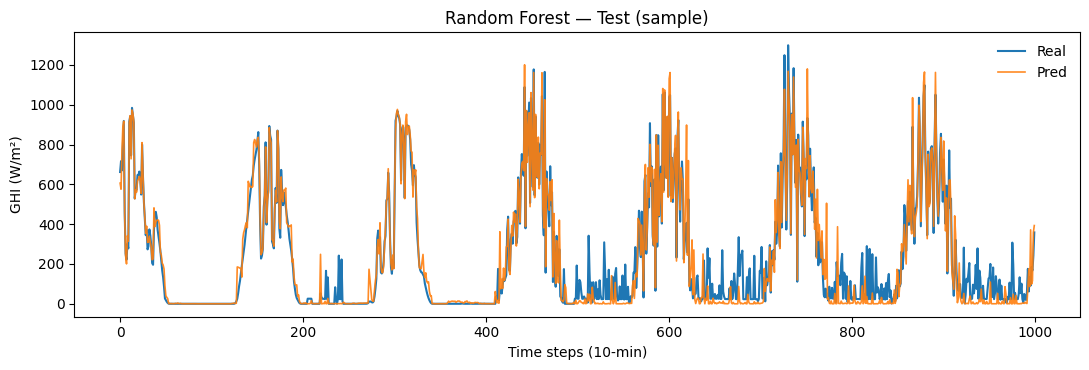

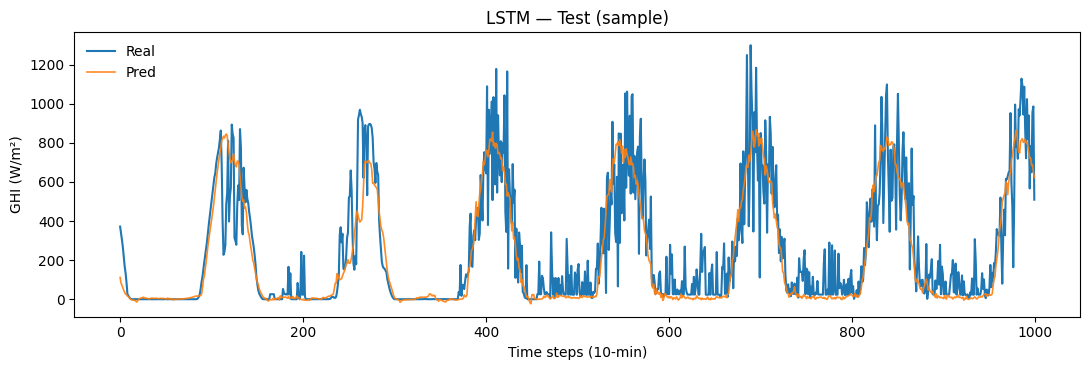

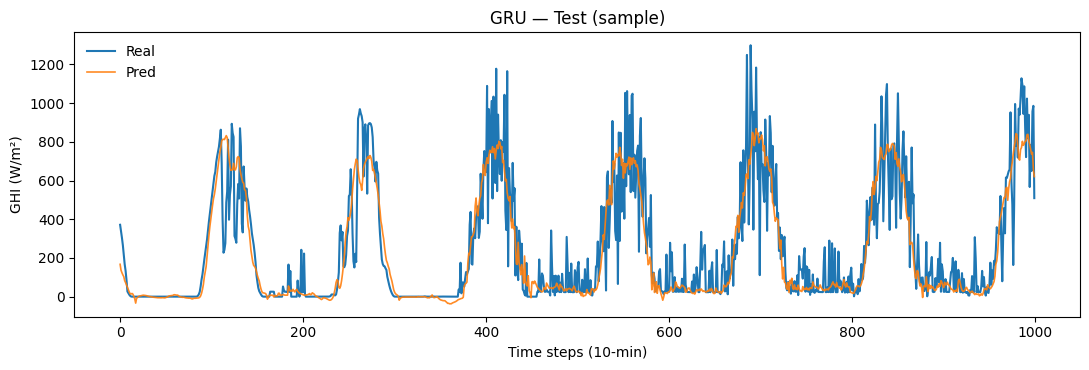

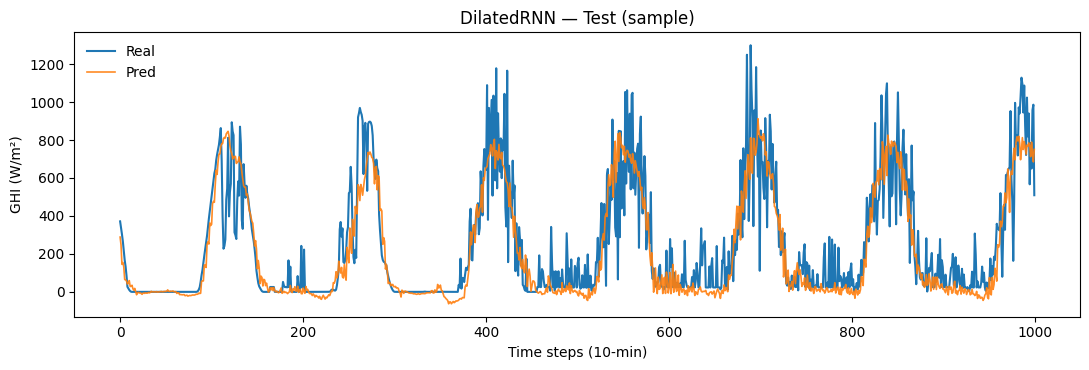

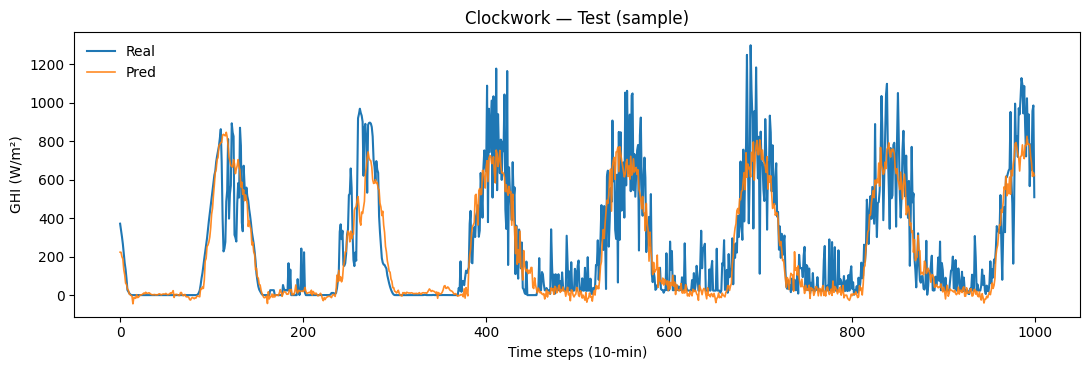

In [18]:
def plot_sample(y_true, y_pred, title, n=1000):
    n = min(n, len(y_true))
    plt.figure(figsize=(11,3.8))
    plt.plot(y_true[:n], label="Real", lw=1.5)
    plt.plot(y_pred[:n], label="Pred", lw=1.2, alpha=0.9)
    plt.title(title)
    plt.xlabel("Time steps (10-min)")
    plt.ylabel("GHI (W/m²)")
    plt.legend(frameon=False)
    plt.tight_layout()

# Baselines
plot_sample(y_true_lin, y_pred_lin, "Linear Regression — Test (sample)")
plt.savefig(FIG_DIR / "pred_linear_sample.png"); plt.show()

plot_sample(y_true_rf, y_pred_rf, "Random Forest — Test (sample)")
plt.savefig(FIG_DIR / "pred_rf_sample.png"); plt.show()

# RNNs
for name, (yt, yp) in series_preds.items():
    plot_sample(yt, yp, f"{name} — Test (sample)")
    plt.savefig(FIG_DIR / f"pred_{name.lower()}_sample.png"); plt.show()

## Results

In [19]:
res_df = pd.DataFrame(results).T.sort_values("RMSE")
display(res_df.round(3))

res_path = ART_DIR / "tabular_results.json"
with open(res_path, "w") as f:
    json.dump({k:{m:float(vv) for m,vv in v.items()} for k,v in results.items()}, f, indent=2)
print("Saved:", res_path)

,MAE,RMSE,MAPE
RandomForest,35.164,57.437,6.026527e+08
GRU,51.021,91.446,5.052614e+07
LSTM,55.325,92.249,9.746136e+07
DilatedRNN,59.805,98.637,1.000382e+08
Clockwork,64.301,102.413,1.542013e+08
LinearRegression,229.843,284.707,5.335739e+09


Saved: ..\outputs\artifacts\tabular_results.json


## Saving

In [20]:
# for name, model in trained.items():
#     save_path = ART_DIR / f"{name}_tabular.pt"
#     torch.save(model.state_dict(), save_path)
# print("Saved models to:", ART_DIR)